In [3]:
import pandas as pd
from collections import Counter

Metagenome CDHIT partitioning of reads didn't pan out, but when I did my initial tests with random short sequences from genomes (that had been partitioned into train/test sets based on their ANI) that seemed to work. So, I'm going to try that again with more genomes. 

the GTDB taxonomy has a good spread of genomes for me to use. The data releases can be found at: https://data.ace.uq.edu.au/public/gtdb/data/releases/latest/

I can download these genomes, split them into train/valid/test sets based on AAI (or ANI), and use either 1) random short chunks of the assembled genome (as I did before), or 2) the original sequencing reads from the SRA (that was later assembled by the submitters for the genome submission) as input to the big model. 

The advantage of using random chunks is that it's very condensed, you're not going to see near-duplicate reads of the same genomic region. The advantage of the original sequencing reads is that they will contain sequencing errors, etc. that are more true to the real world, so maybe will be more robust to real-world imperfections when making predictions on metagenomes/unassembled genomes. 

First things first, I need to:

1) Get a list of genomes I'm going to use from the GTDB (representative species) 

2) Download all the genomes and/or the original SRA reads

3) Generate a pairwise AAI table for all the genomes (or get one that's already published by GTDB?) 

4) Partition genomes into training, validation, and test sets based on AAI cutoff 



In [2]:
clusters = pd.read_csv("sp_clusters.tsv",sep='\t')

In [3]:
len(clusters)

24706

In [9]:
clusters.head()

,Representative genome,GTDB species,GTDB taxonomy,ANI circumscription radius,Mean intra-species ANI,Min intra-species ANI,Mean intra-species AF,Min intra-species AF,No. clustered genomes,Clustered genomes
0,RS_GCF_001027105.1,s__Staphylococcus aureus,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,95.00,98.81,0.88,0.95,0.88,9444,"GB_GCA_000180395.1,GB_GCA_000189435.3,GB_GCA_0..."
1,GB_GCA_002950215.1,s__Escherichia flexneri,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,96.98,97.88,0.74,0.83,0.74,9084,"GB_GCA_000007405.1,GB_GCA_000012025.1,GB_GCA_0..."
2,RS_GCF_000006945.2,s__Salmonella enterica,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,95.00,98.78,0.81,0.94,0.81,8698,"GB_GCA_000180255.1,GB_GCA_000180375.1,GB_GCA_0..."
3,RS_GCF_001457635.1,s__Streptococcus pneumoniae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,95.00,98.62,0.81,0.92,0.81,8201,"GB_GCA_000170015.1,GB_GCA_000170035.1,GB_GCA_0..."
4,RS_GCF_000195955.2,s__Mycobacterium tuberculosis,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,95.00,99.92,0.94,0.99,0.94,5596,"GB_GCA_000152505.1,GB_GCA_000155145.1,GB_GCA_0..."


In [10]:
#metadata = pd.read_csv("bac120_metadata.tsv", sep='\t')

In [5]:
metadata = pd.read_csv("ar122_metadata_r89.tsv",sep='\t')

In [6]:
len(metadata)

2392

In [7]:
metadata.head()

,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count
0,GB_GCA_002503125.1,0,98.40,0.8,188,p__Euryarchaeota (UID3),125,0.0,1639333,76.576757,...,none,none,none,none,none,none,8999,20,41,0
1,GB_GCA_002497145.1,0,77.08,0.8,188,p__Euryarchaeota (UID3),125,0.0,1514651,93.723880,...,558,725,0,90.143,DQ156348.18592.20063,Archaea;Euryarchaeota;Thermoplasmata;Thermopla...,9871,18,31,0
2,GB_GCA_002503185.1,0,85.68,0.0,188,p__Euryarchaeota (UID3),125,0.0,1408875,77.368162,...,1439,2531,0,98.402,FJ167436.1.1440,Archaea;Euryarchaeota;Methanobacteria;Methanob...,69581,20,42,0
3,GB_GCA_002506705.1,0,54.21,0.0,188,p__Euryarchaeota (UID3),125,0.0,1053371,91.473234,...,none,none,none,none,none,none,15699,13,20,0
4,GB_GCA_002497265.1,0,71.22,1.6,188,p__Euryarchaeota (UID3),125,0.0,1151737,88.512361,...,none,none,none,none,none,none,33568,15,30,0


In [77]:
list(metadata.columns)

['accession',
 'ambiguous_bases',
 'checkm_completeness',
 'checkm_contamination',
 'checkm_marker_count',
 'checkm_marker_lineage',
 'checkm_marker_set_count',
 'checkm_strain_heterogeneity',
 'coding_bases',
 'coding_density',
 'contig_count',
 'gc_count',
 'gc_percentage',
 'genome_size',
 'gtdb_genome_representative',
 'gtdb_representative',
 'gtdb_taxonomy',
 'gtdb_type_designation',
 'gtdb_type_designation_sources',
 'gtdb_type_species_of_genus',
 'l50_contigs',
 'l50_scaffolds',
 'longest_contig',
 'longest_scaffold',
 'lsu_23s_contig_len',
 'lsu_23s_count',
 'lsu_23s_length',
 'lsu_23s_query_id',
 'lsu_5s_contig_len',
 'lsu_5s_count',
 'lsu_5s_length',
 'lsu_5s_query_id',
 'lsu_silva_23s_blast_align_len',
 'lsu_silva_23s_blast_bitscore',
 'lsu_silva_23s_blast_evalue',
 'lsu_silva_23s_blast_perc_identity',
 'lsu_silva_23s_blast_subject_id',
 'lsu_silva_23s_taxonomy',
 'mean_contig_length',
 'mean_scaffold_length',
 'mimag_high_quality',
 'mimag_low_quality',
 'mimag_medium_quali

In [74]:
metadata[metadata['accession']=='UBA11423']

,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count
1261,UBA11423,0,72.74,0.65,234,p__Euryarchaeota (UID54),153,0.0,1538740,87.447886,...,none,none,none,none,none,none,1708,10,18,0


In [8]:
list(metadata.columns)

['accession',
 'ambiguous_bases',
 'checkm_completeness',
 'checkm_contamination',
 'checkm_marker_count',
 'checkm_marker_lineage',
 'checkm_marker_set_count',
 'checkm_strain_heterogeneity',
 'coding_bases',
 'coding_density',
 'contig_count',
 'gc_count',
 'gc_percentage',
 'genome_size',
 'gtdb_genome_representative',
 'gtdb_representative',
 'gtdb_taxonomy',
 'gtdb_type_designation',
 'gtdb_type_designation_sources',
 'gtdb_type_species_of_genus',
 'l50_contigs',
 'l50_scaffolds',
 'longest_contig',
 'longest_scaffold',
 'lsu_23s_contig_len',
 'lsu_23s_count',
 'lsu_23s_length',
 'lsu_23s_query_id',
 'lsu_5s_contig_len',
 'lsu_5s_count',
 'lsu_5s_length',
 'lsu_5s_query_id',
 'lsu_silva_23s_blast_align_len',
 'lsu_silva_23s_blast_bitscore',
 'lsu_silva_23s_blast_evalue',
 'lsu_silva_23s_blast_perc_identity',
 'lsu_silva_23s_blast_subject_id',
 'lsu_silva_23s_taxonomy',
 'mean_contig_length',
 'mean_scaffold_length',
 'mimag_high_quality',
 'mimag_low_quality',
 'mimag_medium_quali

In [9]:
ncbicols = ['accession',
            'ncbi_assembly_level',
            'ncbi_assembly_name',
            'ncbi_assembly_type',
            'ncbi_bioproject',
            'ncbi_biosample',
            'ncbi_genbank_assembly_accession',
            'ncbi_genome_category',
            'ncbi_genome_representation',
            'ncbi_organism_name',
            'ncbi_species_taxid',
            'ncbi_taxid',
            'ncbi_wgs_master'
           ]
metadata[ncbicols]

,accession,ncbi_assembly_level,ncbi_assembly_name,ncbi_assembly_type,ncbi_bioproject,ncbi_biosample,ncbi_genbank_assembly_accession,ncbi_genome_category,ncbi_genome_representation,ncbi_organism_name,ncbi_species_taxid,ncbi_taxid,ncbi_wgs_master
0,GB_GCA_002503125.1,Scaffold,ASM250312v1,NaN,PRJNA348753,SAMN06027348,GCA_002503125.1,derived from metagenome,full,Methanobacterium sp. UBA418,1915462,1915462,DARB00000000.1
1,GB_GCA_002497145.1,Scaffold,ASM249714v1,NaN,PRJNA348753,SAMN06027265,GCA_002497145.1,derived from metagenome,full,Euryarchaeota archaeon UBA68,1915972,1915972,DAMT00000000.1
2,GB_GCA_002503185.1,Scaffold,ASM250318v1,NaN,PRJNA348753,SAMN06027632,GCA_002503185.1,derived from metagenome,full,Methanobacterium sp. UBA322,1915437,1915437,DARD00000000.1
3,GB_GCA_002506705.1,Scaffold,ASM250670v1,NaN,PRJNA348753,SAMN06027280,GCA_002506705.1,derived from metagenome,full,Euryarchaeota archaeon UBA550,1915928,1915928,DAYA00000000.1
4,GB_GCA_002497265.1,Scaffold,ASM249726v1,NaN,PRJNA348753,SAMN06027401,GCA_002497265.1,derived from metagenome,full,Euryarchaeota archaeon UBA9,1915982,1915982,DANH00000000.1
5,GB_GCA_002687735.1,Contig,ASM268773v1,NaN,PRJNA391943,SAMN07618689,GCA_002687735.1,derived from metagenome,full,Candidatus Diapherotrites archaeon,2026736,2026736,NZBD00000000.1
6,GB_GCA_002503455.1,Scaffold,ASM250345v1,NaN,PRJNA348753,SAMN06027514,GCA_002503455.1,derived from metagenome,full,Methanosarcina sp. UBA591,1915594,1915594,DARU00000000.1
7,RS_GCF_000189895.1,Contig,ASM18989v2,NaN,PRJNA224116,SAMN02436666,GCA_000189895.2,none,full,Methanobrevibacter smithii TS146D,2173,911121,AELP00000000.1
8,GB_GCA_002780595.1,Scaffold,ASM278059v1,NaN,PRJNA362739,SAMN06659194,GCA_002780595.1,derived from metagenome,full,archaeon (Candidatus Huberarchaea) CG03_land_8...,2014257,2014257,PEUT00000000.1
9,GB_GCA_003170955.1,Scaffold,20110800_E1S,NaN,PRJNA386568,SAMN08179038,GCA_003170955.1,derived from metagenome,full,Methanoregula sp.,2052170,2052170,PMXY00000000.1


In [55]:
reps = metadata[metadata['gtdb_representative']=='t']

In [56]:
len(reps)

1248

In [57]:
reps['ncbi_genbank_assembly_accession'][0:10]

3     GCA_002506705.1
5     GCA_002687735.1
10    GCA_002256595.1
14    GCA_002725275.1
19    GCA_002457605.1
20    GCA_002114285.1
21    GCA_002503285.1
22    GCA_000194625.1
23    GCA_900317865.1
24    GCA_002286985.1
Name: ncbi_genbank_assembly_accession, dtype: object

In [62]:
reps.head()
dict(reps[reps['accession']=='UBA10216'])

{'accession': 140    UBA10216
 Name: accession, dtype: object, 'ambiguous_bases': 140    0
 Name: ambiguous_bases, dtype: int64, 'checkm_completeness': 140    66.28
 Name: checkm_completeness, dtype: float64, 'checkm_contamination': 140    0.0
 Name: checkm_contamination, dtype: float64, 'checkm_marker_count': 140    149
 Name: checkm_marker_count, dtype: int64, 'checkm_marker_lineage': 140    k__Archaea (UID2)
 Name: checkm_marker_lineage, dtype: object, 'checkm_marker_set_count': 140    107
 Name: checkm_marker_set_count, dtype: int64, 'checkm_strain_heterogeneity': 140    0.0
 Name: checkm_strain_heterogeneity, dtype: float64, 'coding_bases': 140    904546
 Name: coding_bases, dtype: int64, 'coding_density': 140    90.28108
 Name: coding_density, dtype: float64, 'contig_count': 140    110
 Name: contig_count, dtype: int64, 'gc_count': 140    504790
 Name: gc_count, dtype: int64, 'gc_percentage': 140    50.412808
 Name: gc_percentage, dtype: float64, 'genome_size': 140    1001922
 Na

In [13]:
len(reps[reps['ncbi_wgs_master']!='none'])

952

In [14]:
print(len(reps))
print(len(Counter(reps['ncbi_biosample'])) )
biosamples = list(Counter(reps['ncbi_biosample']))

1248
1175


In [93]:
import urllib
from lxml import etree
import json
from datetime import datetime
import time

#elink the biosamples to the SRA IDs
def geturl_with_retry(MaxRetry,url):
        while(MaxRetry >= 0):
            try:
                base = urllib.request.urlopen(url)
                base_tree = etree.parse(base)
                base.close()
                base_xml = base_tree.getroot()
                return base_xml
            except Exception:
                print("Internet connectivity Error Retrying in 5 seconds")
                time.sleep(5)
                MaxRetry=MaxRetry - 1

        raise EutilitiesConnectionError("eutilities connection error")

def get_batches(uid_list, batch_size=200):
    starts = list(range(0,len(uid_list),batch_size))
    ends = list(range(batch_size,len(uid_list),batch_size))
    ends.append(len(uid_list))
    batches = [list(a) for a in zip(starts, ends)]
    return batches

def get_links(uid_list, sdict):
    elink_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=biosample&db=sra'
    for key in uid_list:
        #this makes url with end &id=###&id=###&id=### - returns a set of links in order of sra uids
        elink_url = elink_url+'&id='+str(key)
    #run api request and parse xml
    e_parse_time = datetime.now()
    link_xml = geturl_with_retry(MaxRetry=5,url=elink_url)

    try: #sometimes the url is parsed with lxml but is an error xml output from eutilities; this step fails in that case
        linksets = link_xml.findall("LinkSet")
    except Exception:
        raise EutilitiesConnectionError('eutilities connection error')

    e_scrape_time = datetime.now()
    #scrape elink info
    #note if there's no biosample link, <LinkSetDb> with <DbTo>=='biosample' just won't exist
    sra_uids = []

    for linkset in linksets:
        biosample_uid = linkset.find("IdList").findtext("Id")
        #links from each target db will be in a tab called "LinkSetDb"
        if len(linkset.findall("LinkSetDb"))>0:
            for link in linkset.findall("LinkSetDb"):
                id_set = []
                if link.findtext("DbTo")=='sra':
                    #for all Links, get Ids
                    for uid in link.findall("Link"):
                        id_set.append(int(uid.findtext("Id")))
                    sra_uids.extend(id_set)
                    try:
                        sdict[biosample_uid]['srx_uids'] = id_set
                    except KeyError:
                        sdict[biosample_uid] = {}
                        sdict[biosample_uid]['srx_uids'] = id_set

    return sdict

In [79]:
sdict = get_links([8624620,991109], sdict={})
#https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=biosample&db=sra,pubmed&id=8624620&id=991109
sdict

{'8624620': {'srx_uids': [5355447]}, '991109': {'srx_uids': [182036]}}

In [84]:
biosamples

['SAMN02436106',
 'SAMN04634278',
 'SAMN03145057',
 'SAMN05941958',
 'SAMN06456507',
 'SAMD00019276',
 'SAMN08886316',
 'SAMN02470891',
 'SAMN06226398',
 'SAMEA104667096',
 'SAMN06659305',
 'SAMN07372676',
 'SAMN04515684',
 'SAMEA102341668',
 'SAMN06767654',
 'SAMN04315145',
 'SAMN05977994',
 'SAMN06173024',
 'SAMN06453577',
 'SAMN07253282',
 'SAMN03842497',
 'SAMN02256465',
 'SAMN08640882',
 'SAMN02469537',
 'SAMEA4707308',
 'SAMN08107304',
 'SAMN02471618',
 'SAMN08911892',
 'SAMN03271689',
 'SAMN07346487',
 'SAMN04315224',
 'SAMN06450875',
 'SAMN07614990',
 'SAMN07619224',
 'SAMN07618474',
 'SAMD00019863',
 'SAMN07418560',
 'SAMN03002796',
 'SAMEA4591064',
 'SAMD00019181',
 'SAMN08776316',
 'SAMN04009128',
 'SAMN04488032',
 'SAMN05379701',
 'SAMN02949639',
 'SAMN04817514',
 'SAMN07620325',
 'SAMN05912802',
 'SAMN05567582',
 'SAMN06451863',
 'SAMN06455982',
 'SAMEA104666321',
 'SAMN08452421',
 'SAMN08179574',
 'SAMN06451791',
 'SAMN06457848',
 'SAMN06454385',
 'SAMN06457723',
 'SAMEA4

In [45]:
def get_uids(accession):
    esearch_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=biosample&field=ACCN&term='+str(accession)

    link_xml = geturl_with_retry(MaxRetry=5,url=esearch_url)

    try: #sometimes the url is parsed with lxml but is an error xml output from eutilities; this step fails in that case
        idsets = link_xml.findall("IdList")
    except Exception:
        raise EutilitiesConnectionError('eutilities connection error')

    biosample_uids = []

    for idset in idsets:
        biosample_uid = idset.findtext("Id")
        biosample_uids.extend(biosample_uid)

    return biosample_uids

In [47]:
biosample_uids = []
for biosample in biosamples:
    ids = get_uids(biosample)
    biosample_uids.extend(ids)


In [96]:
idsets = link_xml.findall('IdList')

In [105]:
for idset in idsets:
    print(idset.findtext("Id"))

8624620


In [117]:
#get biosample UIDs from accession via MetaSeek
import requests, json
rules_items = [{"field":"biosample_id","type":8, "value":biosamples}]
rules = {"rules":rules_items}
post_data = {'filter_params':json.dumps(rules)}

post = requests.post('https://api.metaseek.cloud/datasets/search/ids', data=post_data)
result = json.loads(post.text) #the parsed result returned from the API.

#this result will be a dictionary with a count of the number of matching datasets ('count_matching_datasets'), the filter parameters that were used ('filter_params'), and a list of dataset metadata summaries ('datasets')
print(result.keys())
matching_datasets = result['matching_dataset_ids']


dict_keys(['filter_params', 'count_matching_datasets', 'matching_dataset_ids'])


In [121]:
result['count_matching_datasets']

11346

In [122]:
#loop through batches of 1000 IDs and query for full metadata for each batch
def get_batches(uid_list, batch_size):
    starts = list(range(0,len(uid_list),batch_size))
    ends = list(range(batch_size,len(uid_list),batch_size))
    ends.append(len(uid_list))
    batches = [list(a) for a in zip(starts, ends)]
    return batches

batch_indexes = get_batches(matching_datasets, batch_size=1000)

import pandas as pd
df = pd.DataFrame()
for batch in batch_indexes:
  batch_id_list = matching_datasets[batch[0]:batch[1]]
  post_data = {'metaseek_ids':str(batch_id_list)}
  print('getting metadata for batch ', batch)
  post_metadata = requests.post('https://api.metaseek.cloud/datasets/metadatafromids', data=post_data)
  result = json.loads(post_metadata.text)
  df = df.append(result['datasets'], ignore_index=True)
df.head()


getting metadata for batch  [0, 1000]
getting metadata for batch  [1000, 2000]
getting metadata for batch  [2000, 3000]
getting metadata for batch  [3000, 4000]
getting metadata for batch  [4000, 5000]
getting metadata for batch  [5000, 6000]
getting metadata for batch  [6000, 7000]
getting metadata for batch  [7000, 8000]
getting metadata for batch  [8000, 9000]
getting metadata for batch  [9000, 10000]
getting metadata for batch  [10000, 11000]
getting metadata for batch  [11000, 11346]


,age,altitude,assembly,avg_read_length_maxrun,baseA_count_maxrun,baseC_count_maxrun,baseG_count_maxrun,baseN_count_maxrun,baseT_count_maxrun,biomaterial_provider,...,study_type_other,submission_id,subspecific_genetic_lineage,target_gene,target_subfragment,taxon_common_name,taxon_scientific_name,tissue,total_num_bases_maxrun,uri
0,None,None,None,235.983,277536030,186015346,186781685,43670,278619231,None,...,None,SRA548074,ATCC 33397,None,None,None,Streptococcus anginosus SK52 = DSM 20563,None,928995962,/dataset/76
1,None,None,None,234.267,67701549,40274552,40284792,6246,67998642,None,...,None,SRA548073,ATCC 33820,None,None,None,Lactobacillus crispatus,None,216265781,/dataset/80
2,None,None,None,2409.840,42403240,69769425,67586053,0,39691122,None,...,None,SRA436100,A5-1,None,None,None,Cupriavidus necator A5-1,None,219449840,/dataset/855
3,None,None,None,100.000,1792392854,1128255556,1140688741,242594,1807307855,None,...,None,SRA083144,ATCC 27405,None,None,None,Ruminiclostridium thermocellum ATCC 27405,None,5868887600,/dataset/2103
4,None,None,vpAllpaths v. r42328,150.000,388041750,1026668594,1002841569,1985638,379904649,None,...,None,SRA420073,URHD0059,None,None,None,Solirubrobacterales bacterium URHD0059,None,2799442200,/dataset/2217


In [123]:
df.to_csv('metadata_from_biosamples_of_gtdb.csv', index=False)

In [4]:
df = pd.read_csv('metadata_from_biosamples_of_gtdb.csv')
df.head()

/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,4,5,7,8,15,22,44,52,68,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,age,altitude,assembly,avg_read_length_maxrun,baseA_count_maxrun,baseC_count_maxrun,baseG_count_maxrun,baseN_count_maxrun,baseT_count_maxrun,biomaterial_provider,...,study_type_other,submission_id,subspecific_genetic_lineage,target_gene,target_subfragment,taxon_common_name,taxon_scientific_name,tissue,total_num_bases_maxrun,uri
0,NaN,NaN,NaN,235.983,277536030,186015346,1.867817e+08,43670,278619231,NaN,...,NaN,SRA548074,ATCC 33397,NaN,NaN,NaN,Streptococcus anginosus SK52 = DSM 20563,NaN,9.289960e+08,/dataset/76
1,NaN,NaN,NaN,234.267,67701549,40274552,4.028479e+07,6246,67998642,NaN,...,NaN,SRA548073,ATCC 33820,NaN,NaN,NaN,Lactobacillus crispatus,NaN,2.162658e+08,/dataset/80
2,NaN,NaN,NaN,2409.840,42403240,69769425,6.758605e+07,0,39691122,NaN,...,NaN,SRA436100,A5-1,NaN,NaN,NaN,Cupriavidus necator A5-1,NaN,2.194498e+08,/dataset/855
3,NaN,NaN,NaN,100.000,1792392854,1128255556,1.140689e+09,242594,1807307855,NaN,...,NaN,SRA083144,ATCC 27405,NaN,NaN,NaN,Ruminiclostridium thermocellum ATCC 27405,NaN,5.868888e+09,/dataset/2103
4,NaN,NaN,vpAllpaths v. r42328,150.000,388041750,1026668594,1.002842e+09,1985638,379904649,NaN,...,NaN,SRA420073,URHD0059,NaN,NaN,NaN,Solirubrobacterales bacterium URHD0059,NaN,2.799442e+09,/dataset/2217


In [7]:
import numpy as np
np.histogram(np.log10(df['library_reads_sequenced_maxrun'].dropna()))

(array([   6,    5,   12,   54,  230, 1591, 3352, 4028, 2021,   47]),
 array([0.        , 0.86430237, 1.72860474, 2.59290712, 3.45720949,
        4.32151186, 5.18581423, 6.0501166 , 6.91441897, 7.77872135,
        8.64302372]))

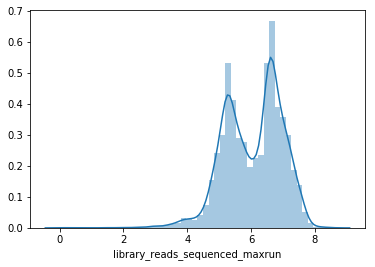

In [8]:
import seaborn as sns
sns.distplot(np.log10(df['library_reads_sequenced_maxrun'].dropna()))

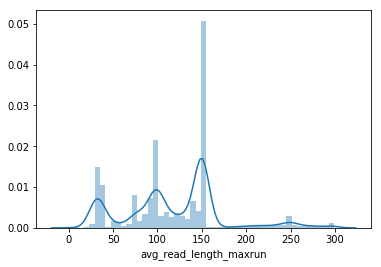

In [9]:
#sns.distplot(np.log10(df['avg_read_length_maxrun'].dropna()))
short = df[df['avg_read_length_maxrun']<300]
sns.distplot(short['avg_read_length_maxrun'].dropna())

In [11]:
print(short.shape)
shortest = short[short['avg_read_length_maxrun']>60]
print(shortest.shape)


(9630, 98)
(7909, 98)


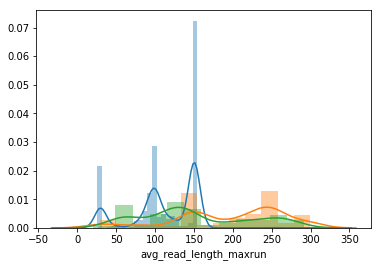

In [158]:
hiseq = short[short['instrument_model'].str.contains('HiSeq', na=False)]
miseq = short[short['instrument_model'].str.contains('MiSeq', na=False)]
four = short[short['instrument_model'].str.contains('454', na=False)]
sns.distplot(hiseq['avg_read_length_maxrun'].dropna())
sns.distplot(miseq['avg_read_length_maxrun'].dropna())
sns.distplot(four['avg_read_length_maxrun'].dropna())

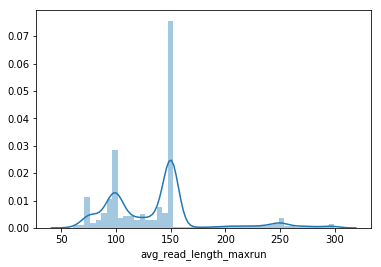

In [21]:
distrib = short[short['avg_read_length_maxrun']>60]['avg_read_length_maxrun'].dropna()
plot = sns.distplot(distrib)
plot.figure.savefig('GTDBGenomeSequencingDistrib.png')

In [185]:
np.mean(distrib)

136.13592208875966

In [183]:
np.save('GTDBGenomeSequencingDistrib.npy',np.array(distrib))

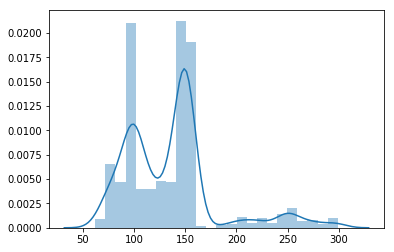

In [12]:
distrib = np.load('GTDBGenomeSequencingDistrib.npy')
sns.distplot(np.random.choice(distrib,size=(1000)))

In [16]:
print(np.mean(distrib))
print(np.median(distrib))
print(np.min(distrib))
print(np.max(distrib))
print(np.percentile(distrib, 25))
print(np.percentile(distrib, 75))

136.13592208875966
144.0
61.0
299.259
100.0
151.0


In [152]:
Counter(short['instrument_model']).most_common()


[('Illumina HiSeq 2000', 3922),
 ('Illumina HiSeq 2500', 2252),
 ('Illumina Genome Analyzer II', 918),
 ('Illumina MiSeq', 756),
 ('NextSeq 500', 541),
 ('454 GS FLX', 465),
 ('Illumina Genome Analyzer IIx', 202),
 ('454 GS FLX Titanium', 173),
 ('Illumina HiSeq 1000', 104),
 ('454 GS 20', 65),
 ('Ion Torrent PGM', 63),
 ('Illumina HiSeq 4000', 52),
 ('Illumina HiSeq 3000', 36),
 ('HiSeq X Ten', 24),
 (nan, 18),
 ('Illumina Genome Analyzer', 11),
 ('Illumina NovaSeq 6000', 11),
 ('454 GS FLX+', 4),
 ('Illumina HiSeq 1500', 4),
 ('454 GS Junior', 2),
 ('AB SOLiD System 3.0', 1),
 ('AB SOLiD 4 System', 1),
 ('Ion Torrent Proton', 1),
 ('454 GS', 1),
 ('PacBio RS II', 1),
 ('Illumina MiniSeq', 1),
 ('Illumina iSeq 100', 1)]

In [136]:
df['avg_read_length_maxrun'].dropna()

0          235.9830
1          234.2670
2         2409.8400
3          100.0000
4          150.0000
5          151.0000
6          248.2530
7          151.0000
8          151.0000
9          151.0000
10         150.0000
11          39.0000
12          36.0000
13         150.0000
14         100.0000
15         151.0000
16         151.0000
17         150.0000
18         150.0000
19         150.0000
20         150.0000
21         150.0000
22         150.0000
23         150.0000
24          54.3231
25          76.0000
26         112.0000
27        3561.8800
28        3588.9100
29        4466.9100
            ...    
11318      150.0000
11319    10031.0000
11320      100.0000
11321       96.0000
11322      150.0000
11323      150.0000
11324      151.0000
11325      151.0000
11326      151.0000
11327      151.0000
11328       25.0000
11329       25.0000
11330       25.0000
11331       25.0000
11332       25.0000
11333       25.0000
11334      150.0000
11335      251.0000
11336      151.0000


In [49]:
Counter(df['metaseek_investigation_type'])

Counter({'bacteria_archaea': 4933,
         'metagenome': 3844,
         'mimarks-survey': 98,
         'eukaryote': 2467,
         'mimarks-culture': 4,
         nan: 2})

In [51]:
Counter(df['metaseek_mixs_specification'])

Counter({'MIGS': 7400, 'MIMS': 3844, 'MIMARKS': 102, nan: 2})

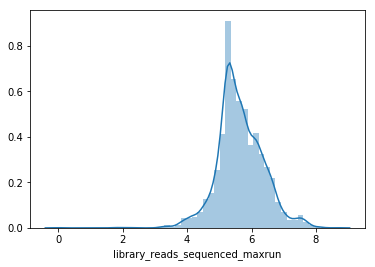

In [50]:
#just metagenomesish
mets = df[df['metaseek_investigation_type']=='metagenome']
sns.distplot(np.log10(mets['library_reads_sequenced_maxrun'].dropna()))

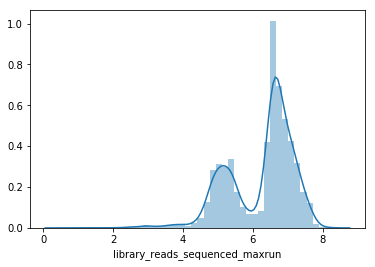

In [52]:
#just metagenomesish
gen = df[df['metaseek_investigation_type']=='bacteria_archaea']
sns.distplot(np.log10(gen['library_reads_sequenced_maxrun'].dropna()))

In [53]:
Counter(df['metaseek_sequencing_method'])

Counter({'illumina': 8525,
         'pacbio_smrt': 1392,
         nan: 584,
         'ls454': 709,
         'oxford_nanopore': 28,
         'ion_torrent': 107,
         'abi_solid': 2,
         'capillary': 1})

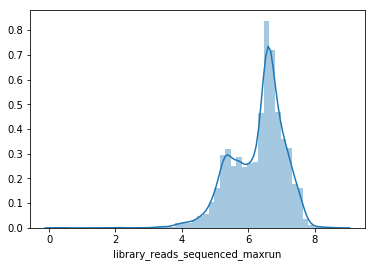

In [54]:
ill = df[df['metaseek_sequencing_method']=='illumina']
sns.distplot(np.log10(ill['library_reads_sequenced_maxrun'].dropna()))

In [55]:
Counter(ill['instrument_model'])

Counter({'Illumina MiSeq': 799,
         'Illumina HiSeq 2000': 3662,
         'Illumina HiSeq 2500': 2194,
         'NextSeq 500': 544,
         'Illumina Genome Analyzer II': 898,
         'Illumina Genome Analyzer IIx': 195,
         'Illumina HiSeq 4000': 54,
         'Illumina HiSeq 1000': 104,
         'Illumina HiSeq 3000': 36,
         'Illumina HiSeq 1500': 4,
         'Illumina Genome Analyzer': 8,
         'HiSeq X Ten': 24,
         'Illumina MiniSeq': 1,
         'Illumina NovaSeq 6000': 1,
         'Illumina iSeq 100': 1})

In [58]:
Counter(ill['metaseek_env_package'])

Counter({nan: 8299,
         'host-associated': 95,
         'water': 56,
         'soil': 38,
         'sediment': 11,
         'plant-associated': 14,
         'human-gut': 1,
         'wastewater/sludge': 9,
         'microbial mat/biofilm': 1,
         'miscellaneous': 1})

In [56]:
low = ill[ill['library_reads_sequenced_maxrun']<1e6]
Counter(low['instrument_model'])

Counter({'Illumina MiSeq': 323,
         'Illumina HiSeq 2500': 383,
         'Illumina HiSeq 2000': 1873,
         'NextSeq 500': 18,
         'Illumina Genome Analyzer II': 44,
         'Illumina HiSeq 3000': 1,
         'Illumina Genome Analyzer': 1,
         'Illumina Genome Analyzer IIx': 25,
         'Illumina HiSeq 1000': 75,
         'Illumina HiSeq 4000': 1,
         'Illumina iSeq 100': 1})

In [57]:
Counter(low['metaseek_env_package'])

Counter({nan: 2694,
         'host-associated': 7,
         'water': 29,
         'soil': 8,
         'plant-associated': 4,
         'sediment': 3})

In [107]:
import datetime
datetime.datetime.strptime(df['metadata_publication_date'][0], '%a, %d %b %Y %H:%M:%S %z')
datetime.date(year=2013,month=1,day=1)
df['datetime'] = pd.to_datetime(df['metadata_publication_date'])

In [122]:
old = df[df['datetime']<'01-01-2014']
new = df[df['datetime']>'01-01-2017']

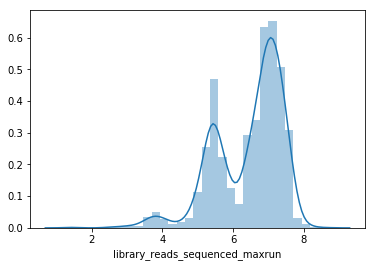

In [123]:
sns.distplot(np.log10(old['library_reads_sequenced_maxrun'].dropna()))

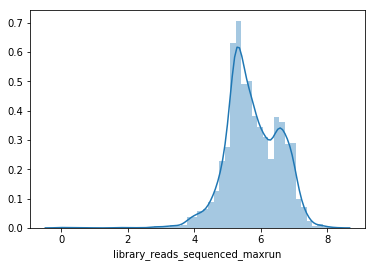

In [124]:
sns.distplot(np.log10(new['library_reads_sequenced_maxrun'].dropna()))


In [131]:
Counter(old['metaseek_sequencing_method'])

Counter({'illumina': 1600,
         nan: 83,
         'ls454': 614,
         'pacbio_smrt': 25,
         'ion_torrent': 15,
         'abi_solid': 2,
         'capillary': 1,
         'oxford_nanopore': 1})

In [132]:
Counter(new['metaseek_sequencing_method'])

Counter({'illumina': 4064,
         'pacbio_smrt': 259,
         'oxford_nanopore': 22,
         'ion_torrent': 5,
         'ls454': 12,
         nan: 2})

So there are only 11k or so GTDB representative genomes that have SRX raw reads associated with them, it appears. For now, let's go about downloading all the genomes directly, and maybe revisit the SRRs saved in 'metadata_from_biosamples_of_gtdb.csv' for raw reads later. 

So now I need to link the GTDB metadata to their ftp paths

In [15]:
#link gtdb data to their ftp paths
assemblies = pd.read_csv("assembly_summary_genbank.txt", sep="\t", skiprows=1)

In [16]:
impt = ["# assembly_accession","bioproject", "biosample", "organism_name","assembly_level","refseq_category",
        "genome_rep","asm_name","ftp_path"]

In [17]:
assemblies[impt].head()

,# assembly_accession,bioproject,biosample,organism_name,assembly_level,refseq_category,genome_rep,asm_name,ftp_path
0,GCA_000001215.4,PRJNA13812,SAMN02803731,Drosophila melanogaster,Chromosome,reference genome,Full,Release 6 plus ISO1 MT,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...
1,GCA_000001405.28,PRJNA31257,NaN,Homo sapiens,Chromosome,reference genome,Full,GRCh38.p13,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...
2,GCA_000001515.5,PRJNA13184,SAMN02981217,Pan troglodytes,Chromosome,na,Full,Pan_tro 3.0,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...
3,GCA_000001545.3,PRJNA20869,SAMN02981238,Pongo abelii,Chromosome,na,Full,P_pygmaeus_2.0.2,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...
4,GCA_000001635.8,PRJNA20689,NaN,Mus musculus,Chromosome,reference genome,Full,GRCm38.p6,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...


In [11]:
clusters.head()

,Representative genome,GTDB species,GTDB taxonomy,ANI circumscription radius,Mean intra-species ANI,Min intra-species ANI,Mean intra-species AF,Min intra-species AF,No. clustered genomes,Clustered genomes
0,RS_GCF_001027105.1,s__Staphylococcus aureus,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,95.00,98.81,0.88,0.95,0.88,9444,"GB_GCA_000180395.1,GB_GCA_000189435.3,GB_GCA_0..."
1,GB_GCA_002950215.1,s__Escherichia flexneri,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,96.98,97.88,0.74,0.83,0.74,9084,"GB_GCA_000007405.1,GB_GCA_000012025.1,GB_GCA_0..."
2,RS_GCF_000006945.2,s__Salmonella enterica,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,95.00,98.78,0.81,0.94,0.81,8698,"GB_GCA_000180255.1,GB_GCA_000180375.1,GB_GCA_0..."
3,RS_GCF_001457635.1,s__Streptococcus pneumoniae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,95.00,98.62,0.81,0.92,0.81,8201,"GB_GCA_000170015.1,GB_GCA_000170035.1,GB_GCA_0..."
4,RS_GCF_000195955.2,s__Mycobacterium tuberculosis,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,95.00,99.92,0.94,0.99,0.94,5596,"GB_GCA_000152505.1,GB_GCA_000155145.1,GB_GCA_0..."


In [13]:
genomes = [genome[3:] for genome in clusters['Representative genome']]

In [26]:
notin = []
for genome in genomes:
    if genome not in list(assemblies['# assembly_accession']):
        notin.append(genome)

In [27]:
len(notin)

11497

In [19]:
len(genomes)

24706

hmmmmm there should be more than that... will look in to it

# Join reps and assemblies to get ftp paths for each rep genome

In [27]:
reps[reps['ncbi_genbank_assembly_accession']=='none']
items = [item.split('_',maxsplit=1)[-1] for item in reps['accession']]
reps['parsed_genome_accession'] = items

/anaconda3/envs/tree/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
reps[reps['ncbi_genbank_assembly_accession']=='none']
list(reps.columns)
#reps[reps['ncbi_genbank_assembly_accession']=='none']['ncbi_isolate']

['accession',
 'ambiguous_bases',
 'checkm_completeness',
 'checkm_contamination',
 'checkm_marker_count',
 'checkm_marker_lineage',
 'checkm_marker_set_count',
 'checkm_strain_heterogeneity',
 'coding_bases',
 'coding_density',
 'contig_count',
 'gc_count',
 'gc_percentage',
 'genome_size',
 'gtdb_genome_representative',
 'gtdb_representative',
 'gtdb_taxonomy',
 'gtdb_type_designation',
 'gtdb_type_designation_sources',
 'gtdb_type_species_of_genus',
 'l50_contigs',
 'l50_scaffolds',
 'longest_contig',
 'longest_scaffold',
 'lsu_23s_contig_len',
 'lsu_23s_count',
 'lsu_23s_length',
 'lsu_23s_query_id',
 'lsu_5s_contig_len',
 'lsu_5s_count',
 'lsu_5s_length',
 'lsu_5s_query_id',
 'lsu_silva_23s_blast_align_len',
 'lsu_silva_23s_blast_bitscore',
 'lsu_silva_23s_blast_evalue',
 'lsu_silva_23s_blast_perc_identity',
 'lsu_silva_23s_blast_subject_id',
 'lsu_silva_23s_taxonomy',
 'mean_contig_length',
 'mean_scaffold_length',
 'mimag_high_quality',
 'mimag_low_quality',
 'mimag_medium_quali

In [30]:
rep_impt = ['ncbi_assembly_name','ncbi_genbank_assembly_accession','ncbi_bioproject','ncbi_biosample',
            'ncbi_assembly_level','ncbi_organism_name','ncbi_refseq_category','ncbi_genome_representation',
           'parsed_genome_accession']
print(len(reps))
print(len(reps[rep_impt].dropna()))

1248
1248


In [31]:
historical = pd.read_csv("assembly_summary_genbank_historical.txt", sep="\t", skiprows=1)
print(len(historical))
print(len(assemblies))
print(len(historical)+len(assemblies))

16105
553900
570005


In [32]:
full = assemblies.append(historical)
len(full)

570005

In [33]:
reps.index = reps['ncbi_genbank_assembly_accession']
full.index = full['# assembly_accession']
joined = reps[rep_impt].join(full[['# assembly_accession','ftp_path','asm_name']])

In [78]:
print(len(joined))
joined.head()

1248


,ncbi_assembly_name,ncbi_genbank_assembly_accession,ncbi_bioproject,ncbi_biosample,ncbi_assembly_level,ncbi_organism_name,ncbi_refseq_category,ncbi_genome_representation,parsed_genome_accession,# assembly_accession,ftp_path,asm_name
GCA_000006175.2,ASM617v2,GCA_000006175.2,PRJNA224116,SAMN00000040,Complete Genome,Methanococcus voltae A3,representative genome,full,GCF_000006175.1,GCA_000006175.2,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ASM617v2
GCA_000006805.1,ASM680v1,GCA_000006805.1,PRJNA224116,SAMN02604216,Complete Genome,Halobacterium salinarum NRC-1,representative genome,full,GCF_000006805.1,GCA_000006805.1,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ASM680v1
GCA_000007185.1,ASM718v1,GCA_000007185.1,PRJNA294,SAMN02603235,Complete Genome,Methanopyrus kandleri AV19,na,full,GCA_000007185.1,GCA_000007185.1,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ASM718v1
GCA_000007225.1,ASM722v1,GCA_000007225.1,PRJNA172,SAMN02604075,Complete Genome,Pyrobaculum aerophilum str. IM2,na,full,GCA_000007225.1,GCA_000007225.1,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ASM722v1
GCA_000007305.1,ASM730v1,GCA_000007305.1,PRJNA224116,SAMN02604284,Complete Genome,Pyrococcus furiosus DSM 3638,representative genome,full,GCF_000007305.1,GCA_000007305.1,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ASM730v1


In [89]:
tofind = joined[joined.isna().any(axis=1)]
print(len(tofind))
tofind.head()

65


,ncbi_assembly_name,ncbi_genbank_assembly_accession,ncbi_bioproject,ncbi_biosample,ncbi_assembly_level,ncbi_organism_name,ncbi_refseq_category,ncbi_genome_representation,parsed_genome_accession,# assembly_accession,ftp_path,asm_name
UBA10036,none,none,none,none,none,none,none,none,UBA10036,NaN,NaN,NaN
UBA10106,none,none,none,none,none,none,none,none,UBA10106,NaN,NaN,NaN
UBA10107,none,none,none,none,none,none,none,none,UBA10107,NaN,NaN,NaN
UBA10117,none,none,none,none,none,none,none,none,UBA10117,NaN,NaN,NaN
UBA10136,none,none,none,none,none,none,none,none,UBA10136,NaN,NaN,NaN


In [106]:
def get_srxs(term):
    esearch_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=sra&term='+str(term)

    link_xml = geturl_with_retry(MaxRetry=5,url=esearch_url)

    try: #sometimes the url is parsed with lxml but is an error xml output from eutilities; this step fails in that case
        idsets = link_xml.findall("IdList")
    except Exception:
        raise EutilitiesConnectionError('eutilities connection error')

    uids = []

    for idset in idsets:
        uid = idset.findtext("Id")    
        uids.append(uid)

    return uids

In [109]:
matching_datasets = []
for term in tofind['parsed_genome_accession']:
    print('searching term',term)
    match = get_srxs(term)
    matching_datasets.extend(match)

searching term UBA10036
searching term UBA10106
searching term UBA10107
searching term UBA10117
Internet connectivity Error Retrying in 5 seconds
searching term UBA10136
searching term UBA10154
searching term UBA10161
Internet connectivity Error Retrying in 5 seconds
searching term UBA10192
searching term UBA10194
searching term UBA10200
Internet connectivity Error Retrying in 5 seconds
searching term UBA10204
searching term UBA10205
searching term UBA10207
Internet connectivity Error Retrying in 5 seconds
searching term UBA10210
searching term UBA10214
searching term UBA10216
Internet connectivity Error Retrying in 5 seconds
searching term UBA10219
searching term UBA10242
searching term UBA10516
Internet connectivity Error Retrying in 5 seconds
searching term UBA10536
searching term UBA10834
searching term UBA10923
Internet connectivity Error Retrying in 5 seconds
searching term UBA11020
searching term UBA11384
searching term UBA11423
Internet connectivity Error Retrying in 5 seconds


In [110]:
print(len(matching_datasets))
print(matching_datasets[0:10])
match

65
['9552481', '9552492', '9552503', '9552529', '9552551', '9552418', '9552429', '9552467', '9552469', '9552471']


['9552461']

In [ ]:
batch_indexes = get_batches(matching_datasets, batch_size=1000)

import pandas as pd
df = pd.DataFrame()
for batch in batch_indexes:
  batch_id_list = matching_datasets[batch[0]:batch[1]]
  post_data = {'metaseek_ids':str(batch_id_list)}
  print('getting metadata for batch ', batch)
  post_metadata = requests.post('https://api.metaseek.cloud/datasets/metadatafromids', data=post_data)
  result = json.loads(post_metadata.text)
  df = df.append(result['datasets'], ignore_index=True)
df.head()

In [53]:

list(reps.columns)
cols = ['ncbi_assembly_level',
 'ncbi_assembly_name',
 'ncbi_assembly_type',
 'ncbi_bioproject',
 'ncbi_biosample',
 'ncbi_contig_count',
 'ncbi_contig_n50',
 'ncbi_country',
 'ncbi_date',
 'ncbi_genbank_assembly_accession',
 'ncbi_genome_category',
 'ncbi_genome_representation',
 'ncbi_isolate',
 'ncbi_isolation_source',
 'ncbi_lat_lon',
 'ncbi_molecule_count',
 'ncbi_ncrna_count',
 'ncbi_organism_name',
 'ncbi_protein_count',
 'ncbi_refseq_category',
 'ncbi_rrna_count',
 'ncbi_scaffold_count',
 'ncbi_scaffold_l50',
 'ncbi_scaffold_n50',
 'ncbi_scaffold_n75',
 'ncbi_scaffold_n90',
 'ncbi_seq_rel_date',
 'ncbi_spanned_gaps',
 'ncbi_species_taxid',
 'ncbi_ssu_count',
 'ncbi_strain_identifiers',
 'ncbi_submitter',
 'ncbi_taxid',
 'ncbi_taxonomy',
 'ncbi_taxonomy_unfiltered',
 'ncbi_total_gap_length',
 'ncbi_total_length',
 'ncbi_translation_table',
 'ncbi_trna_count',
 'ncbi_type_material_designation',
 'ncbi_ungapped_length',
 'ncbi_unspanned_gaps',
 'ncbi_wgs_master']
list(reps[reps['parsed_genome_accession'].isin(toadd['parsed_genome_accession'])].iloc[0,])

['UBA10216',
 0,
 66.28,
 0.0,
 149,
 'k__Archaea (UID2)',
 107,
 0.0,
 904546,
 90.2810797647,
 110,
 504790,
 50.4128079831,
 1001922,
 'UBA10216',
 't',
 'd__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o__Woesearchaeales;f__UBA10216;g__UBA10216;s__UBA10216 sp10216u',
 'none',
 'none',
 'none',
 26,
 26,
 39685,
 39697,
 'none',
 0,
 'none',
 'none',
 'none',
 0,
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 9102,
 9452,
 'f',
 'f',
 't',
 12266,
 12268,
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'derived from metagenome',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 1210,
 106,
 'none',
 0,
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 '

In [35]:
print(len(joined))
print(len(joined.dropna()))
toadd = joined[joined['ncbi_genbank_assembly_accession']=='none']
joined = joined.dropna()

1248
1183


In [36]:
toadd.index = toadd['parsed_genome_accession']
toadd2 = toadd[rep_impt].join(full[['# assembly_accession','ftp_path','asm_name']])
toadd2.head()

,ncbi_assembly_name,ncbi_genbank_assembly_accession,ncbi_bioproject,ncbi_biosample,ncbi_assembly_level,ncbi_organism_name,ncbi_refseq_category,ncbi_genome_representation,parsed_genome_accession,# assembly_accession,ftp_path,asm_name
UBA10036,none,none,none,none,none,none,none,none,UBA10036,NaN,NaN,NaN
UBA10106,none,none,none,none,none,none,none,none,UBA10106,NaN,NaN,NaN
UBA10107,none,none,none,none,none,none,none,none,UBA10107,NaN,NaN,NaN
UBA10117,none,none,none,none,none,none,none,none,UBA10117,NaN,NaN,NaN
UBA10136,none,none,none,none,none,none,none,none,UBA10136,NaN,NaN,NaN


In [37]:
print(len(toadd2))
print(len(toadd2['asm_name'].dropna()))
print(len(toadd2['# assembly_accession'].dropna()))

65
0
0


In [38]:
joined = joined.append(toadd2)
joined = joined.drop_duplicates()
print(len(joined))
print(len(joined['ftp_path'].dropna()))

1248
1183


In [152]:
#deal with special cases
joined.at[723,'asm_name'] = 'HIMB114_v2.0'
joined.loc[723]

ncbi_assembly_name                                                      HIMB114 v2.0
ncbi_genbank_assembly_accession                                      GCA_000163555.2
ncbi_bioproject                                                          PRJNA224116
ncbi_biosample                                                          SAMN02436217
ncbi_assembly_level                                                           Contig
ncbi_organism_name                                     alpha proteobacterium HIMB114
ncbi_refseq_category                                                              na
ncbi_genome_representation                                                      full
parsed_genome_accession                                              GCF_000163555.2
# assembly_accession                                                 GCA_000163555.2
ftp_path                           ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...
asm_name                                                         

In [171]:
splits = [len(asm.split(' ')) for asm in joined['asm_name']]
Counter(splits)
for ix, asm in joined.iterrows():
    split = str(asm['asm_name']).split(' ')
    if len(split) > 1:
        print(ix, asm['ftp_path'], split)
        #join by an underscore instead
        joined.at[ix,'asm_name'] = '_'.join(['Draft', 'genome', 'sequence', 'of', 'PAMC', '26794'])

1499 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/262/345/GCA_000262345.1_Streptomyces_sulphureus_L180_version_1.0 ['Streptomyces', 'sulphureus', 'L180,', 'version', '1.0']
1506 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/263/275/GCA_000263275.1_Helicobacter_bizzozeronii_CCUG_35545 ['Helicobacter', 'bizzozeronii', 'CCUG', '35545']
1550 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/271/485/GCA_000271485.2_Pelosinus_fermentans_DSM_17108_v1.1 ['Pelosinus', 'fermentans', 'DSM', '17108_v1.1']
1861 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/313/615/GCA_000313615.1_Velvet_assembly_of_Campylobacter_showae_CSUNSWCD ['Velvet', 'assembly', 'of', '', 'Campylobacter', 'showae', 'CSUNSWCD']
1862 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/313/755/GCA_000313755.1_Pseudomonas_sp.TX1_v1.0 ['Pseudomonas', 'sp.TX1_v1.0']
1886 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/315/795/GCA_000315795.1_Caenispirillum_salinarum ['Caenispirillum', 'salinarum']
1888 ftp://ftp.ncbi.nlm.nih.gov/genomes/

4044 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/685/215/GCA_000685215.1_SOAPdenovo_v1.05 ['SOAPdenovo', 'v1.05']
4045 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/685/235/GCA_000685235.1_SOAPdenovo_v1.05 ['SOAPdenovo', 'v1.05']
4046 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/685/275/GCA_000685275.1_SOAPdenovo_v1.05 ['SOAPdenovo', 'v1.05']
4047 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/685/295/GCA_000685295.1_SOAPdenovo_v1.05 ['SOAPdenovo', 'v1.05']
4048 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/685/315/GCA_000685315.1_SOAPdenovo_v1.05 ['SOAPdenovo', 'v1.05']
4121 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/690/905/GCA_000690905.1_Pseudomonas_sp._Ant30-3 ['Pseudomonas', 'sp.', 'Ant30-3']
4125 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/691/385/GCA_000691385.1_MhyoNPL7v1.0_of_Mycoplasma_hyosynoviae_strain_NPL7_genome ['MhyoNPL7v1.0', 'of', 'Mycoplasma', 'hyosynoviae', 'strain', 'NPL7', 'genome']
4126 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/691/525/GCA_000

6968 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/444/295/GCA_001444295.1_Pseudomonas_fluorescens_GcM5-1A ['Pseudomonas', 'fluorescens', 'GcM5-1A']
6995 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/457/415/GCA_001457415.1_Gorillibacterium_timonense ['Gorillibacterium', 'timonense']
6996 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/457/435/GCA_001457435.1_Actinobaculum_massiliense ['Actinobaculum', 'massiliense']
7007 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/457/795/GCA_001457795.1_Olsenella_massiliensis ['Olsenella', 'massiliensis']
7008 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/457/815/GCA_001457815.1_Vitreoscilla_massiliensis ['Vitreoscilla', 'massiliensis']
7009 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/457/835/GCA_001457835.1_Micromassilia_timonensis ['Micromassilia', 'timonensis']
7010 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/458/075/GCA_001458075.1_JGI_assembly ['JGI', 'assembly']
7011 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/458/115/GCA_00145811

11195 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/002/204/795/GCA_002204795.1_Pseudomonas_sp ['Pseudomonas', 'sp']
12769 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/002/355/395/GCA_002355395.1_Microcella_alkaliphila_JAM_AC0309_assembly_01 ['Microcella_alkaliphila_JAM_AC0309_assembly', '01']
12778 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/002/355/595/GCA_002355595.1_F._lacunae_YT21-2 ['F.', 'lacunae', 'YT21-2']
16408 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/002/798/275/GCA_002798275.1_NML_08-0793 ['NML', '08-0793']
20007 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/010/755/GCA_900010755.1_Pseudoclavibacter_helvolus_strain_W3 ['Pseudoclavibacter', 'helvolus,', 'strain', 'W3']
20012 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/014/985/GCA_900014985.1_Draft_genome_of_Kocuria_varians_G6 ['Draft', 'genome', 'of', 'Kocuria', 'varians', 'G6']
20013 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/014/995/GCA_900014995.1_Draft_genome_of_Pseudoclavibacter_helvolus_G8 ['Draft', 'genome', 'of',

20828 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/109/575/GCA_900109575.1_IMG-taxon_2599185177_annotated_assembly ['IMG-taxon', '2599185177', 'annotated', 'assembly']
20829 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/109/605/GCA_900109605.1_IMG-taxon_2617270885_annotated_assembly ['IMG-taxon', '2617270885', 'annotated', 'assembly']
20830 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/109/615/GCA_900109615.1_IMG-taxon_2687453776_annotated_assembly ['IMG-taxon', '2687453776', 'annotated', 'assembly']
20831 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/109/645/GCA_900109645.1_IMG-taxon_2616644845_annotated_assembly ['IMG-taxon', '2616644845', 'annotated', 'assembly']
20832 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/109/655/GCA_900109655.1_IMG-taxon_2651870358_annotated_assembly ['IMG-taxon', '2651870358', 'annotated', 'assembly']
20833 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/109/665/GCA_900109665.1_IMG-taxon_2634166326_annotated_assembly ['IMG-taxon', '2634166326', 'anno

21538 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/142/675/GCA_900142675.1_IMG-taxon_2654588196_annotated_assembly ['IMG-taxon', '2654588196', 'annotated', 'assembly']
21539 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/142/695/GCA_900142695.1_IMG-taxon_2700988712_annotated_assembly ['IMG-taxon', '2700988712', 'annotated', 'assembly']
21540 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/142/705/GCA_900142705.1_IMG-taxon_2671180073_annotated_assembly ['IMG-taxon', '2671180073', 'annotated', 'assembly']
21541 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/142/715/GCA_900142715.1_IMG-taxon_2698536748_annotated_assembly ['IMG-taxon', '2698536748', 'annotated', 'assembly']
21542 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/142/725/GCA_900142725.1_IMG-taxon_2698536749_annotated_assembly ['IMG-taxon', '2698536749', 'annotated', 'assembly']
21543 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/142/735/GCA_900142735.1_IMG-taxon_2698536752_annotated_assembly ['IMG-taxon', '2698536752', 'anno

22410 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/316/075/GCA_900316075.1_Rumen_uncultured_genome_RUG151 ['Rumen', 'uncultured', 'genome', 'RUG151']
22411 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/316/105/GCA_900316105.1_Rumen_uncultured_genome_RUG161 ['Rumen', 'uncultured', 'genome', 'RUG161']
22412 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/316/115/GCA_900316115.1_Rumen_uncultured_genome_RUG154 ['Rumen', 'uncultured', 'genome', 'RUG154']
22413 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/316/125/GCA_900316125.1_Rumen_uncultured_genome_RUG163 ['Rumen', 'uncultured', 'genome', 'RUG163']
22414 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/316/145/GCA_900316145.1_Rumen_uncultured_genome_RUG159 ['Rumen', 'uncultured', 'genome', 'RUG159']
22415 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/316/165/GCA_900316165.1_Rumen_uncultured_genome_RUG170 ['Rumen', 'uncultured', 'genome', 'RUG170']
22416 ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/316/175/GCA_900316175.1_Rumen_uncul

In [172]:
joined.at[1499,'asm_name'] = 'Streptomyces_sulphureus_L180_version_1.0'

In [176]:
joined[joined['# assembly_accession']=='GCA_000263275.1']
joined.at[1506,'asm_name'] = 'Helicobacter_bizzozeronii_CCUG_35545'
joined[joined['# assembly_accession']=='GCA_000263275.1']

,ncbi_assembly_name,ncbi_genbank_assembly_accession,ncbi_bioproject,ncbi_biosample,ncbi_assembly_level,ncbi_organism_name,ncbi_refseq_category,ncbi_genome_representation,parsed_genome_accession,# assembly_accession,ftp_path,asm_name
1506,Helicobacter bizzozeronii CCUG 35545,GCA_000263275.1,PRJNA224116,SAMEA2272226,Contig,Helicobacter bizzozeronii CCUG 35545,na,full,GCF_000263275.1,GCA_000263275.1,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,Helicobacter_bizzozeronii_CCUG_35545


In [207]:
toreplace = joined.loc[(joined['ncbi_assembly_name']!=joined['asm_name'])&(joined['ncbi_assembly_name']!='none'),][2:]
toreplace.head()
for ix in toreplace.index:
    new = '_'.join(toreplace.loc[ix,'ncbi_assembly_name'].split(' '))
    joined.at[ix,'asm_name'] = new

In [208]:
joined.loc[1862,]

ncbi_assembly_name                                           Pseudomonas sp.TX1_v1.0
ncbi_genbank_assembly_accession                                      GCA_000313755.1
ncbi_bioproject                                                          PRJNA224116
ncbi_biosample                                                          SAMN02470611
ncbi_assembly_level                                                           Contig
ncbi_organism_name                                     Pseudomonas nitroreducens TX1
ncbi_refseq_category                                                              na
ncbi_genome_representation                                                      full
parsed_genome_accession                                              GCF_000313755.1
# assembly_accession                                                 GCA_000313755.1
ftp_path                           ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...
asm_name                                                     Pseu

In [211]:
joined[joined['# assembly_accession']=='GCA_000313615.1']
joined.at[1861,'asm_name'] = 'Velvet_assembly_of_Campylobacter_showae_CSUNSWCD'

In [212]:
joined.to_csv("GTDBrepGenomes_withftp.csv", index=False)

In [2]:
joined = pd.read_csv("GTDBrepGenomes_withftp.csv")

In [3]:
len(joined)

23458

In [9]:
joined.loc[3020,]

ncbi_assembly_name                                                Smit.str17/34_v1.0
ncbi_genbank_assembly_accession                                      GCA_000430305.1
ncbi_bioproject                                                          PRJNA206048
ncbi_biosample                                                          SAMN02470848
ncbi_assembly_level                                                           Contig
ncbi_organism_name                                         Streptococcus mitis 17/34
ncbi_refseq_category                                                              na
ncbi_genome_representation                                                      full
parsed_genome_accession                                              GCA_000430305.1
# assembly_accession                                                 GCA_000430305.1
ftp_path                           ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...
asm_name                                                         

In [10]:
#remove , or " characters; replace a double __ or / chr with single _
joined.head()

,ncbi_assembly_name,ncbi_genbank_assembly_accession,ncbi_bioproject,ncbi_biosample,ncbi_assembly_level,ncbi_organism_name,ncbi_refseq_category,ncbi_genome_representation,parsed_genome_accession,# assembly_accession,ftp_path,asm_name
0,ASM582v2,GCA_000005825.2,PRJNA224116,SAMN02603086,Complete Genome,Bacillus pseudofirmus OF4,representative genome,full,GCF_000005825.2,GCA_000005825.2,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ASM582v2
1,ASM668v1,GCA_000006685.1,PRJNA224116,SAMN02603994,Complete Genome,Chlamydia muridarum str. Nigg,representative genome,full,GCF_000006685.1,GCA_000006685.1,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ASM668v1
2,ASM694v2,GCA_000006945.2,PRJNA57799,SAMN02604315,Complete Genome,Salmonella enterica subsp. enterica serovar Ty...,reference genome,full,GCF_000006945.2,GCA_000006945.2,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ASM694v2
3,ASM696v1,GCA_000006965.1,PRJNA57603,SAMEA3283068,Complete Genome,Sinorhizobium meliloti 1021,reference genome,full,GCF_000006965.1,GCA_000006965.1,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ASM696v1
4,ASM698v1,GCA_000006985.1,PRJNA57897,SAMN02604006,Complete Genome,Chlorobaculum tepidum TLS,reference genome,full,GCF_000006985.1,GCA_000006985.1,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ASM698v1


In [17]:
errors = [
1892,
2125,
2146,
2626,
3020,
3326,
3345,
3382,
3488,
3776,
4002,
4003,
4004,
4005,
4006,
4007,
4008,
4009,
4010,
4012,
4126,
4868,
5535,
5876,
5899,
5941,
5942,
5943,
5944,
5945,
5946,
5947,
6039,
6049,
6265,
6266,
6267,
6268,
6428,
6440,
6466,
6468,
6469,
6470,
6471,
6474,
6475,
6476,
6477,
20007,
20032,
20046,
20048,
20049,
20050,
20051,
20052,
20053,
20054,
20055,
20056,
20057,
20058,
20059,
20060,
20061,
20062,
20063,
20064,
20065,
20066,
20067,
20068,
20069,
20070,
20071,
20072,
20073,
20074,
20075,
20076,
20077,
20078,
20079,
20080,
20081,
20082,
20083,
20084,
20085,
20086,
20087,
20088,
20089,
20105,
20106,
20258,
]

In [18]:
len(errors)

97

In [30]:
#take the last bit of the ftp path and make that the asm_name
for ix in errors:
    new_asm = '_'.join(joined.loc[ix, 'ftp_path'].split('/')[-1].split('_')[2:])
    print(new_asm)
    joined.at[ix,'asm_name'] = new_asm

Paenibacillus_sonchi_X19-5T
_Ca._Caldatribacterium_californiense_
D15-8W.seq.sqn_for_a_Marinobacter_nanhaiticus_assembly_version_1.0
Trep_dent_SP32_F0464_V1
Smit.str17_34_v1.0
ASM46853v1
BiG_1.1
_oprFasNSB1
NGEN_DNA_Star_
M2_40
ASM63325v1
ASM63335v1
ASM63339v1
ASM63341v1
ASM63343v1
ASM63345v1
ASM63351v1
ASM63353v1
ASM63357v2
NGEN_DNA_Star_
ATCC25795_good_1_paired_assembly
CelMixJ3-8_1.0
SBR5_T_
BRSU_AN4859_03
5139_1_3
6775_1_8
5139_5_4
8016_2_91
6823_7_22
5139_2_1
4840_6_2
6680_6_10
7067_4_69
8016_2_92
2_2
11861_6_29
11861_6_19
11861_6_21
6938_6_7
Draft_genome_of_P._immobile_strain_E_DSM_1986_
13470_2_95
13414_6_14
14207_7_86
14207_7_25
14207_7_37
13470_2_75
13414_6_7
13414_6_33
13414_6_47
Pseudoclavibacter_helvolus_strain_W3
11860_6_86
16473_4_70
12718_7_92
12718_7_94
13414_6_2
13414_6_3
13414_6_15
13414_6_20
13414_6_28
13414_6_32
13414_6_37
13414_6_45
13414_6_60
13414_6_64
13414_6_66
13414_6_67
13414_6_68
13414_6_69
13414_6_70
13470_2_58
13470_2_62
13470_2_64
13470_2_73
13470_2_78
13

In [31]:
joined.to_csv("GTDBrepGenomes_withftp.csv", index=False)